<a href="https://colab.research.google.com/github/Hassan7838/roman-urdu-cyber-abuse-detection/blob/main/roman-urdu-cyber-abuse-detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cyber Abuse Detection in Roman Urdu using Machine Learning

# Import Necessary Libraries

import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [ ]:
# Upload and Load Dataset

from google.colab import files
upload = files.upload()

df = pd.read_csv('roman_urdu_comments.csv')
df.head()

# H = hate (abusive)
# O = okay (non-abusive)

Saving roman_urdu_comments.csv to roman_urdu_comments (2).csv


,id,comment,label
0,1,Aray bakwaas baatein mat kar lol,H
1,2,Mashallah shukriya share karne ke liye bhai,O
2,3,ARAY KYA FALTU! INSAN HY BRO,H
3,4,tum :) smajhta kyaa haii apne aap ko lol,H
4,5,good luck for neext project bro,O


In [ ]:
# Missing Values and Duplicates

print("Total rows:", len(df))
print("Missing values per column:\n", df.isnull().sum())

# If comments missing then drop
df = df.dropna(subset=['comment']).reset_index(drop=True)
print("After dropping missing comments:", len(df))

# Duplicates
dups = df.duplicated(subset=['comment']).sum()
print("Duplicate rows (by comment column) : ", dups)
df = df.drop_duplicates(subset=['comment']).reset_index(drop=True)
print("After dropping duplicates:", len(df))

Total rows: 5004
Missing values per column:
 id         0
comment    0
label      0
dtype: int64
After dropping missing comments: 5004
Duplicate rows (by comment column) :  420
After dropping duplicates: 4584


In [ ]:
# Preprocessing Function for Roman Urdu

roman_stopwords = {
    "aur","ke","hai","haiy","ko","ka","ke","ki","kya","kia","tu","tum","mein","main","nahi","nhi","na","bhe","bhai"
}

normalization_map = {
    "kia": "kya",
    "ky": "kya",
    "acha": "accha",
    "acha": "accha",
    "nai": "nahi",
    "nhi": "nahi",
}

def preprocess_text(text):
    text = str(text)
    text = text.lower()
    text = re.sub(r'http\S+|www\.\S+', ' ', text)           # remove urls
    text = re.sub(r'@\w+', ' ', text)                       # remove mentions
    text = re.sub(r'#\w+', ' ', text)                       # remove hashtags
    # remove punctuation but keep spaces
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    # normalize elongated characters (e.g., sooo -> so)
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)
    # normalize spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # map common variants
    tokens = text.split()
    tokens = [normalization_map.get(tok, tok) for tok in tokens]
    return " ".join(tokens)

# Apply Function
df['clean'] = df['comment'].apply(preprocess_text)
df[['comment','clean','label']].head(10)

,comment,clean,label
0,Aray bakwaas baatein mat kar lol,aray bakwaas baatein mat kar lol,H
1,Mashallah shukriya share karne ke liye bhai,mashallah shukriya share karne ke liye bhai,O
2,ARAY KYA FALTU! INSAN HY BRO,aray kya faltu insan hy bro,H
3,tum :) smajhta kyaa haii apne aap ko lol,tum smajhta kyaa haii apne aap ko lol,H
4,good luck for neext project bro,good luck for neext project bro,O
5,Mashallah tera accent!! ajeeb hey bhai,mashallah tera accent ajeeb hey bhai,H
6,Bhai very helpful :) :) bro,bhai very helpful bro,O
7,Haye awesome creativity :),haye awesome creativity,O
8,Haye very clean editing ok,haye very clean editing ok,O
9,very clean editing :),very clean editing,O


In [ ]:
# Inspect Noisy/Outliers (extreme length comments)

df['length'] = df['clean'].apply(lambda x: len(x.split()))
print("Short comments (<=1 token):", (df['length']<=1).sum())
print("Very long comments (>100 tokens):", (df['length']>100).sum())

Short comments (<=1 token): 0
Very long comments (>100 tokens): 0


In [ ]:
# Prepare X, y and train_test split (75/25)
X = df['clean']
y = df['label'].map({ 'H' : 1 , 'O' : 0 })   # 1 = Hate(abusive) , 0 = Okay(non-abusive)

from collections import Counter
print("Class distribution:", Counter(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
print("Train size:", len(X_train), ", Test size:", len(X_test))

Class distribution: Counter({1: 2335, 0: 2249})
Train size: 3438 , Test size: 1146


In [ ]:
# Feature Extraction & Model Pipelines

tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=3)

models = {
    'MultinomialNB': MultinomialNB(),
    'LogisticRegression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'LinearSVC': LinearSVC(class_weight='balanced', max_iter=2000)
}

pipelines = {}
for name, clf in models.items():
    pipe = Pipeline([
        ('tfidf', tfidf),
        ('clf', clf)
    ])
    pipelines[name] = pipe

# Train
for name, pipe in pipelines.items():
    print("Training:", name)
    pipe.fit(X_train, y_train)
    joblib.dump(pipe, f"{name}_pipeline.joblib")   # save each pipeline

Training: MultinomialNB
Training: LogisticRegression
Training: LinearSVC


In [ ]:
# Evaluation on Test Set
results = {}
for name, pipe in pipelines.items():
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)
    results[name] = {'accuracy':acc, 'precision':prec, 'recall':rec, 'f1':f1, 'cm':cm}
    print(f"\n{name} Classification Report:\n", classification_report(y_test, y_pred, target_names=['O','H']))
    print("Confusion Matrix:\n", cm)


MultinomialNB Classification Report:
               precision    recall  f1-score   support

           O       0.99      1.00      1.00       562
           H       1.00      0.99      1.00       584

    accuracy                           1.00      1146
   macro avg       1.00      1.00      1.00      1146
weighted avg       1.00      1.00      1.00      1146

Confusion Matrix:
 [[562   0]
 [  4 580]]

LogisticRegression Classification Report:
               precision    recall  f1-score   support

           O       0.99      1.00      0.99       562
           H       1.00      0.99      0.99       584

    accuracy                           0.99      1146
   macro avg       0.99      0.99      0.99      1146
weighted avg       0.99      0.99      0.99      1146

Confusion Matrix:
 [[561   1]
 [  5 579]]

LinearSVC Classification Report:
               precision    recall  f1-score   support

           O       0.99      1.00      0.99       562
           H       1.00      0.99  

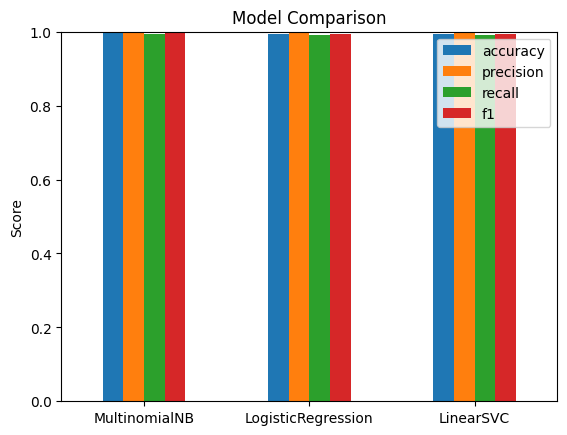

In [ ]:
# Plot Comparison Bar Chart (accuracy, precision, recall, f1)
metrics = ['accuracy','precision','recall','f1']
df_res = pd.DataFrame({name: {m: results[name][m] for m in metrics} for name in results}).T
df_res.plot.bar(rot=0)
plt.title("Model Comparison")
plt.ylabel("Score")
plt.ylim(0,1)
plt.show()

In [ ]:
# Make Prediction on User Input

choice = 1
while(choice == 1):

    print("\n****************************************************")
    input_msg = str(input("\n\nEnter a Roman Urdu comment: "))
    msg = preprocess_text(input_msg)

    for name, pipe in pipelines.items():
        pred = pipe.predict([msg])
        print("====================================================")
        print(f"Model {name} prediction :")
        if (pred[0] == 1):
            print("Abusive")
        else:
            print("Non-Abusive")

    choice = int(input("\n===>> Enter 1 to continue or 0 to exit: "))
    if (choice == 0):
        break

print("Exit Program...")


****************************************************


Enter a Roman Urdu comment: aby kia bakwas video he yar
Model MultinomialNB prediction :
Abusive
Model LogisticRegression prediction :
Abusive
Model LinearSVC prediction :
Abusive

===>> Enter 1 to continue or 0 to exit: 1

****************************************************


Enter a Roman Urdu comment: yar kia ajeeb banda he
Model MultinomialNB prediction :
Abusive
Model LogisticRegression prediction :
Abusive
Model LinearSVC prediction :
Abusive

===>> Enter 1 to continue or 0 to exit: 1

****************************************************


Enter a Roman Urdu comment: bro zabardast video he yar
Model MultinomialNB prediction :
Non-Abusive
Model LogisticRegression prediction :
Non-Abusive
Model LinearSVC prediction :
Non-Abusive

===>> Enter 1 to continue or 0 to exit: 1

****************************************************


Enter a Roman Urdu comment: aby ja tou chala ja yahan se 
Model MultinomialNB prediction :
Abusive
Mo